In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import pickle
import os

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

GeForce GTX 1080 Ti


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
DATA_VERSION = 'v8'
MODEL_VERSION = 'v9'

DATA_ROOT = os.path.join('data', DATA_VERSION)
MODEL_ROOT = os.path.join('model', MODEL_VERSION)

TRAIN = os.path.join(DATA_ROOT, f'train.pkl')
TEST = os.path.join(DATA_ROOT, f'test.pkl')
WORD_IX = os.path.join(DATA_ROOT, f'word_ix.pkl')
IX_WORD = os.path.join(DATA_ROOT, f'ix_word.pkl')

In [5]:
train = pickle.load(open(TRAIN, 'rb'))
test = pickle.load(open(TEST, 'rb'))
word_ix = pickle.load(open(WORD_IX, 'rb'))
ix_word = pickle.load(open(IX_WORD, 'rb'))
encoded_headlines = train + test

In [6]:
print('length of train: ', len(train))
print('length of test: ', len(test))

length of train:  8500
length of test:  1500


In [7]:
# General structure learned from PyTorch documentation
class myLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size, embedding_size):
        super(myLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        #self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, words):    
        
        h = torch.zeros(1, 1, self.hidden_size, requires_grad=False).to(device)
        c = torch.zeros(1, 1, self.hidden_size, requires_grad=False).to(device)
        
        # embed words
        w_embedding = self.embedding(words)
        w_embedding = w_embedding.view(len(words), 1, self.embedding_size)

        # run the lstm layer
        output, (h, c) = self.lstm(w_embedding, (h, c))  
        output = self.dropout(output)
        result = self.linear(output)
        
        return result

In [8]:
# in_size = max_len-1 # should be size of the inputting sentence/batch (how many words are being inputted)
h_size = 128 # should be size of learned parameters
out_size = len(word_ix) # should be size of vocab
vocab_size = len(word_ix) # total unique words in corpus
embed_size = 64 # dimension of each word's embedding

learning_rate = 0.001
num_epochs = 50


model = myLSTM(h_size, out_size, vocab_size, embed_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []

for i in range(num_epochs):
    total_loss = 0
     
    for s in train:
        
        optimizer.zero_grad()
        
        # predict until the word right before the last word
        predictions = model(torch.tensor(s, requires_grad=False)[:-1].to(device))    
        
        # loss = sent_loss(predictions, s).cpu()
        # print(predictions)
        loss = criterion(predictions.squeeze(), torch.tensor(s, requires_grad=False)[1:].to(device)).cpu()
        total_loss += loss.detach().numpy()

        loss.backward()
        optimizer.step()
        
    avg_total_loss = total_loss / len(train)
    losses.append(avg_total_loss)
    diff = losses[i]-losses[i-1] if i > 0 else 0
    print('epoch: ', i, 'loss: ', avg_total_loss, 'difference: ', diff)

epoch:  0 loss:  7.6639845438564524 difference:  0
epoch:  1 loss:  7.011729007173987 difference:  -0.6522555366824658
epoch:  2 loss:  6.711311985997592 difference:  -0.30041702117639435
epoch:  3 loss:  6.433407591328901 difference:  -0.277904394668691
epoch:  4 loss:  6.1700429408129525 difference:  -0.2633646505159488
epoch:  5 loss:  5.917203027332531 difference:  -0.2528399134804218
epoch:  6 loss:  5.703338821789798 difference:  -0.2138642055427331
epoch:  7 loss:  5.522836843714995 difference:  -0.18050197807480295
epoch:  8 loss:  5.370218721642214 difference:  -0.1526181220727807
epoch:  9 loss:  5.2385973006486894 difference:  -0.13162142099352447
epoch:  10 loss:  5.132812015175819 difference:  -0.10578528547287025
epoch:  11 loss:  5.058000464839094 difference:  -0.07481155033672504
epoch:  12 loss:  4.989880590060178 difference:  -0.06811987477891623
epoch:  13 loss:  4.936391308475943 difference:  -0.05348928158423494
epoch:  14 loss:  4.883080105234595 difference:  -0.0

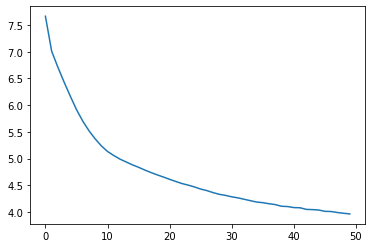

In [9]:
plt.plot(losses)

In [10]:
# saving models and trained parameters
def saveModel(model, name, root, description):
    model = model.cpu()
    
    if os.path.exists(root) == False:
        os.makedirs(root)
    
    desc = open(os.path.join(root, 'description.txt'), 'w')
    desc.write(description + '\n')
    desc.close()
    
    pickle.dump(model, open(name, 'wb'))

In [11]:
def convertToWord(s, ixw, wix):
    res = ''
    for w in s:
        print(w)
        res += ixw[w] + ' '
    return res

In [12]:
def testModel(model, testSet, device, encoded_headlines):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        for s in testSet:
            
            # predict until the word right before the last word
            predictions = model(torch.tensor(s[:-1], requires_grad=False).to(device))
            #pred = [np.argmax(predictions[i].cpu().detach().numpy()) for i in range(len(predictions))]
            #print('predicted: ', pred, 'truth: ', s)
            
            loss = criterion(predictions.squeeze(), torch.tensor(s)[1:].to(device)).cpu()   
            total_loss += loss.detach().numpy()
            #print('loss: ', loss, 's: ', s)
            
        print('total_loss: ', total_loss)
        print('len(testSet): ', len(testSet))
        avg_total_loss = total_loss / len(testSet)

        print('avg. loss on test set: ', avg_total_loss)
    
    model.train()

In [38]:
def predictSent(modelName, sentence, wordIndex):
    # model = torch.load(modelName)
    model = pickle.load(open(modelName, 'rb'))
    model = model.to(device)
    model.eval()
    max_len = 5
    sent_words = sentence.split()
    encoded_sent = [word_ix['<START>']] + [word_ix[w] for w in sentence.split()]
    
    ix_word = defaultdict(str)
    for w in wordIndex:
        ix_word[wordIndex[w]] = w
    
    # predict until we reach the END signal
    while True:
        with torch.no_grad():
            preds = model(torch.tensor(encoded_sent, requires_grad=False).to(device))
        softmax = nn.Softmax(dim=1)
        preds = softmax(preds.squeeze())
        #print(torch.sum(preds[-1]))
        pred_word = preds[-1].cpu().detach().numpy().tolist()
        
        pred_word = list(zip(pred_word, range(len(pred_word))))
        pred_word.sort(reverse=True)
        
        
        # randomly from the top k words to be the next word
        k = 3
        next_word = random.choice(pred_word[:k])
        while len(encoded_sent) < max_len and next_word[1] == word_ix['<END>']:
            next_word = random.choice(pred_word[:k])

        #print(next_word)
        encoded_sent.append(next_word[1])
        
        if len(encoded_sent) >= max_len and next_word[1] == word_ix['<END>']:
            break
        
    # decode the sentence afterward
    pred_sentence = [ix_word[i] for i in encoded_sent]
    
    model.train()
    return pred_sentence

In [15]:
model_name = os.path.join(MODEL_ROOT, f'model.pkl')
model_desc = f'{num_epochs} epochs, {len(train)} training size, {h_size} hidden size, {embed_size} embedding size, dropout=0.3'
saveModel(model, model_name, MODEL_ROOT, model_desc)

In [16]:
# model = torch.load('model_v4-50_epochs-8k-512h.pt')
model = pickle.load(open(model_name, 'rb'))
model = model.to(device)

In [17]:
testModel(model, test, device, encoded_headlines)

total_loss:  15780.271886110306
len(testSet):  1500
avg. loss on test set:  10.52018125740687


In [39]:
for i in range(10):
    sent = 'car'
    pred = predictSent(model_name, sent, word_ix)
    print(' '.join(pred))

<START> car urges tax war crackdown in two <END>
<START> car fatal defends left a good council <END>
<START> car urges accident to community title <END>
<START> car crash victims victims fire on pakistan from world <END>
<START> car fatal down of australia river quake study says <END>
<START> car fatal down over after site accident by <END>
<START> car crash kills 10 years <END>
<START> car fatal down after china faces another proposal peace of council on <END>
<START> car crash kills three as iron first test <END>
<START> car fatal down after china as nsw risk study farmers <END>
